### Start by creating a new Notebook for this assignment.

In [1]:
import pandas as pd
import numpy as np
import requests
import re
!pip install coordinates-converter
from coordinates.converter import convert_degrees_to_decimal

###### Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe


Note: There are different website scraping libraries and packages in Python. For scraping the above table, you can simply use pandas to read the table into a pandas dataframe.

Another way, which would help to learn for more complicated cases of web scraping is using the BeautifulSoup package. Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

The package is so popular that there is a plethora of tutorials and examples on how to use it. Here is a very good Youtube video on how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k

Use pandas, or the BeautifulSoup package, or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe.

# Load CSV and format them to combine info about each city and the Geographical coordinates

In [2]:
#df = pd.read_csv(url)  FORBIDDEN D:
#I'm just gonna load it on Github
df = pd.read_csv("comuni.csv",skiprows =1)
df_lib1 = df[["Codice Comune","Descrizione Comune","Numero medio di componenti per famiglia","Popolazione al 31 dicembre - Totale"]] #Less Is Better
df_lib1.index = df_lib1["Codice Comune"]
df_lib1= df_lib1.drop(columns="Codice Comune")


df_geo = pd.read_csv("comuni2.csv", sep=";",header=None )
df_geo.columns = columns=["Regione","Provincia","Comune","Lat1","Lat2","Lat3","Long1", "Long2", "Long3","Altitude", "Alt min", "Alt max", "Superficie", "Population", "Descrizione Comune", "Targa"]

df_lib2 = df_geo[["Regione","Descrizione Comune","Altitude"]] #Less Is Better
df_lib2["Lat"] = df_geo.apply(lambda row: convert_degrees_to_decimal(float(row["Lat1"]),float(row["Lat2"]), float(row["Lat3"])) , axis = 1)
df_lib2["Long"] = df_geo.apply(lambda row: convert_degrees_to_decimal(float(row["Long1"]),float(row["Long2"]), float(row["Long3"])) , axis = 1)

df_lib2.head()

df_lib = pd.merge(left =df_lib2, right =  df_lib1, on="Descrizione Comune", how="left" )

df_lib=df_lib.rename(columns={"Numero medio di componenti per famiglia":"AvgHousehold", "Descrizione Comune":"city", "Lat":"lat", "Long":"lng","Popolazione al 31 dicembre - Totale":"popu"})

print(df_lib.shape)
df_lib.AvgHousehold=df_lib.AvgHousehold.fillna(df_lib.AvgHousehold.mean())
df_lib= df_lib[df_lib.popu.notna()]
df_lib.head()

C:\Users\i1B259859\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\i1B259859\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(8118, 7)


Regione             city  Altitude        lat       lng  AvgHousehold  \
1        1          Airasca       257  44.917500  7.491111           2.4   
2        1     Ala di Stura      1080  45.316111  7.302778           1.9   
3        1  Albiano d'Ivrea       230  45.435000  7.947222           2.2   
4        1  Alice Superiore       610  45.462222  7.777778           2.0   
5        1           Almese       364  45.120000  7.398056           2.2   

     popu  
1  3726.0  
2   456.0  
3  1677.0  
4   725.0  
5  6409.0

# Data analysis: let's discover a little bit more about our Italian towns


In [3]:
"""
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
"""

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
from IPython.core.display import HTML
from IPython.display import display
# create map of New York using latitude and longitude values
rome_lat = df_lib.loc[df_lib['city'] == "Roma", "lat"].values[0]
rome_lng = df_lib.loc[df_lib['city'] == "Roma", "lng"].values[0]
map_italy = folium.Map(location=[rome_lat, rome_lng], zoom_start=6)


df_lib_short = df_lib[df_lib.popu > 8000]
print(df_lib_short.shape)

# add markers to map
for lat, lng, size in zip(df_lib_short['lat'], df_lib_short['lng'], df_lib_short['popu']):
    folium.CircleMarker(
        [lat, lng],
        radius=(size/8000)**(1/3),
        color='blue',
        parse_html=False).add_to(map_italy)  
    
display(map_italy)

(1494, 7)


In [5]:
!pip install --upgrade google-api-python-client oauth2client
!pip install ipython-secrets

Requirement already up-to-date: google-api-python-client in c:\users\i1b259859\appdata\local\continuum\anaconda3\lib\site-packages (1.7.11)
Requirement already up-to-date: oauth2client in c:\users\i1b259859\appdata\local\continuum\anaconda3\lib\site-packages (4.1.3)


In [6]:
import ipython_secrets
CLIENT_ID = ipython_secrets .get_secret('CLIENT_ID')
CLIENT_SECRET = ipython_secrets .get_secret('CLIENT_SECRET')
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + "LOL secret here")
print('CLIENT_SECRET:' + "LOL secret here")

Your credentails:
CLIENT_ID: LOL secret here
CLIENT_SECRET:LOL secret here


In [7]:
from time import sleep
sleep(2)

## Let's search the best venues for each city

In [8]:
from datetime import datetime




def getNearbyVenues(names, latitudes, longitudes, radius=20000, LIMIT = 50):
    
        tick = datetime.now()
        calls=0
        calls_pro_hour = 0
        tock = None
        venues_list=[]
        for name, lat, lng in tqdm(zip(names, latitudes, longitudes)):
            # create the API request URL
            #print(str(int(calls_pro_hour * 100)/100) + "\t" + name)
            calls+=1
            undone=True
            while(undone):
                try:
                    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                        CLIENT_ID, 
                        CLIENT_SECRET, 
                        VERSION, 
                        lat, 
                        lng, 
                        radius, 
                        LIMIT)

                    # make the GET request
                    results = requests.get(url).json()["response"]['groups'][0]['items']
                    undone=False
                except Exception as e:
                    print()
                    print("ERROR - sleeping 1 minute - City name: "+ name)
                    sleep(10)
                    undone=True
                        
                
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'],
                v['venue']['id']) for v in results])
            tock = datetime.now()   
            diff = tock - tick 
            minutes = diff.total_seconds() / 60
            calls_pro_hour = calls / (minutes / 60)
            if calls > 100 and calls_pro_hour > 4800:
                print("calls_pro_hour > 4800, slowing down for two minutes", flush=True)
                sleep(120)



        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['City', 
                      'City Latitude', 
                      'City Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category',
                      'Venue ID']

        return(nearby_venues)

In [9]:
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

In [10]:
df_lib=df_lib.drop(df_lib[df_lib.city=="Brusson"].index)
list_dfs = {}
for region in list(range(1,21)):
    print()
    print()
    print()
    print(region)
    df_s = df_lib[df_lib.Regione==region]
    list_dfs[region] = (getNearbyVenues(names=df_s['city'],
                                   latitudes=df_s['lat'],
                                   longitudes=df_s['lng']
                                  ))





1


100it [01:07,  1.73it/s]

calls_pro_hour > 4800, slowing down for two minutes


101it [03:08, 36.62s/it]


ERROR - sleeping 1 minute - City name: Foglizzo


110it [03:41,  3.03s/it]


ERROR - sleeping 1 minute - City name: Giaveno


1163it [18:32,  1.05it/s]





2


61it [00:41,  1.46it/s]





3


1489it [20:19,  1.22it/s]





4


100it [01:12,  1.51it/s]

calls_pro_hour > 4800, slowing down for two minutes


146it [03:46,  1.55s/it]





5


463it [07:42,  1.40it/s]


ERROR - sleeping 1 minute - City name: San Martino di Lupari


539it [09:20,  1.04s/it]





6


205it [02:55,  1.17it/s]





7


75it [01:19,  1.57s/it]


ERROR - sleeping 1 minute - City name: Cairo Montenotte


87it [01:49,  1.24it/s]


ERROR - sleeping 1 minute - City name: Dego


111it [02:37,  1.45it/s]


ERROR - sleeping 1 minute - City name: Pontinvrea


225it [04:33,  1.21s/it]





8


154it [03:04,  1.41it/s]


ERROR - sleeping 1 minute - City name: Modena


171it [03:35,  1.34it/s]


ERROR - sleeping 1 minute - City name: Sassuolo


316it [05:55,  1.12s/it]





9


100it [01:12,  1.40it/s]

calls_pro_hour > 4800, slowing down for two minutes


142it [03:47,  1.33it/s]


ERROR - sleeping 1 minute - City name: Montopoli in Val d'Arno


263it [05:32,  1.26s/it]





10


89it [00:58,  1.51it/s]





11


231it [04:08,  1.07s/it]





12


100it [01:01,  1.73it/s]

calls_pro_hour > 4800, slowing down for two minutes


374it [06:40,  1.07s/it]





13


166it [02:04,  1.68it/s]

calls_pro_hour > 4800, slowing down for two minutes


304it [05:28,  1.08s/it]





14


100it [00:51,  2.11it/s]

calls_pro_hour > 4800, slowing down for two minutes


134it [03:09,  1.41s/it]





15


100it [01:05,  1.51it/s]

calls_pro_hour > 4800, slowing down for two minutes


543it [07:41,  1.18it/s]





16


100it [01:02,  1.32it/s]

calls_pro_hour > 4800, slowing down for two minutes


254it [04:47,  1.13s/it]





17


100it [00:55,  2.01it/s]

calls_pro_hour > 4800, slowing down for two minutes


130it [03:12,  1.48s/it]





18


144it [01:48,  1.98it/s]

calls_pro_hour > 4800, slowing down for two minutes


395it [06:22,  1.03it/s]





19


100it [01:02,  1.69it/s]

calls_pro_hour > 4800, slowing down for two minutes


137it [03:26,  1.64it/s]


ERROR - sleeping 1 minute - City name: Malvagna


170it [04:26,  1.34s/it]


ERROR - sleeping 1 minute - City name: San Pier Niceto


176it [04:50,  1.73s/it]


ERROR - sleeping 1 minute - City name: Santa Lucia del Mela


375it [07:15,  1.16s/it]





20


100it [00:56,  1.51it/s]

calls_pro_hour > 4800, slowing down for two minutes


357it [05:24,  1.10it/s]


In [19]:
venues=pd.concat(list(list_dfs.values())).reset_index(drop=True)
venues.to_csv("venues.csv")

In [32]:
df_venues=venues
print(len(df_venues))
df_venues.head()

308432


City  City Latitude  City Longitude                             Venue  \
0  Airasca        44.9175        7.491111                       Zoom Torino   
1  Airasca        44.9175        7.491111        Tenuta La Cascinetta Hotel   
2  Airasca        44.9175        7.491111                      Des Artistes   
3  Airasca        44.9175        7.491111                    Enfant Prodige   
4  Airasca        44.9175        7.491111  Palazzina di Caccia di Stupinigi   

   Venue Latitude  Venue Longitude Venue Category                  Venue ID  
0       44.933005         7.420028            Zoo  4be560b82457a5939560ab15  
1       44.885050         7.428310          Hotel  4bd5b2f49649ce72b588511d  
2       44.953619         7.513382    Pizza Place  4d570c5d143ca093e241c3fc  
3       44.956770         7.407666            Pub  4d3366eb6c7c721ee80ab956  
4       44.996827         7.606236         Castle  4c421856a5c5ef3be96ab06f

In [ ]:
"""def getVenueReview(ids,names):
    
    qualty_list=[]
    for idd,name in zip(ids, names):
        print()
        print(name)
        print(idd)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            idd,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        reply = requests.get(url).json()
        try:
            results = reply["response"]["venue"]
        
        
            # return only relevant information for each nearby venue
        
            qualty_list.append((
                idd,
                name,
                results['rating'], 
                results['likes']['count'], 
                results['dislike'],   
                results['tips']['count']))
            print("Vote {} and tipcount {}".format(results['rating'],results['tips']['count']))
        except Exception as e:
            print('Error: '+ str(e))
            results = {}
            qualty_list.append((
                idd,
                name,
                None, 
                None, 
                None,   
                None))

    nearby_venues = pd.DataFrame([item for item in qualty_list])
    nearby_venues.columns = ['Venue ID', 
                  'Venue', 
                  'Venue Rating', 
                  'Venue Likes', 
                  'Venue Dislikes', 
                  'Venue Tips Count']
    
    return(nearby_venues,results)"""

In [ ]:
"""df_quality, query2_results = getVenueReview(ids=df_venues['Venue ID'][:10],
                                   names=df_venues['Venue'][:10]
                                  )"""

# Here I combine a little the data I've computed so far, just to ensure that everything is up to date

In [33]:
df_sizes = df_venues.groupby("City").size().rename("size").reset_index().copy()

df_sizes = df_sizes.rename(columns={"City":"city"})
df_lib2 = pd.merge(left = df_lib, right = df_sizes, on="city", how="left")
df_lib2 = df_lib2.rename(columns={"city":"City"})
df_lib2.head()

Regione             City  Altitude        lat       lng  AvgHousehold  \
0        1          Airasca       257  44.917500  7.491111           2.4   
1        1     Ala di Stura      1080  45.316111  7.302778           1.9   
2        1  Albiano d'Ivrea       230  45.435000  7.947222           2.2   
3        1  Alice Superiore       610  45.462222  7.777778           2.0   
4        1           Almese       364  45.120000  7.398056           2.2   

     popu  size  
0  3726.0    50  
1   456.0    14  
2  1677.0    50  
3   725.0    50  
4  6409.0    50

In [34]:
df_venues2 = pd.merge(left = df_venues, right = df_lib2, on="City", how="left")
df_venues2.head()

City  City Latitude  City Longitude                             Venue  \
0  Airasca        44.9175        7.491111                       Zoom Torino   
1  Airasca        44.9175        7.491111        Tenuta La Cascinetta Hotel   
2  Airasca        44.9175        7.491111                      Des Artistes   
3  Airasca        44.9175        7.491111                    Enfant Prodige   
4  Airasca        44.9175        7.491111  Palazzina di Caccia di Stupinigi   

   Venue Latitude  Venue Longitude Venue Category                  Venue ID  \
0       44.933005         7.420028            Zoo  4be560b82457a5939560ab15   
1       44.885050         7.428310          Hotel  4bd5b2f49649ce72b588511d   
2       44.953619         7.513382    Pizza Place  4d570c5d143ca093e241c3fc   
3       44.956770         7.407666            Pub  4d3366eb6c7c721ee80ab956   
4       44.996827         7.606236         Castle  4c421856a5c5ef3be96ab06f   

   Regione  Altitude      lat       lng  AvgHousehold    popu  size  
0        1       257  44.9175  7.491111           2.4  3726.0    50  
1        1       257  44.9175  7.491111           2.4  3726.0    50  
2        1       257  44.9175  7.491111           2.4  3726.0    50  
3        1       257  44.9175  7.491111           2.4  3726.0    50  
4        1       257  44.9175  7.491111           2.4  3726.0    50

In [52]:
df_venues2.loc[df_venues2["Venue Category"].value_counts()[df_venues2["Venue Category"]].values < 500, "Venue Category"] = "Original"

## Let's hot-encode the venue category field!

In [56]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot["Regione"] = df_venues2['Regione'] 
df_onehot.index = df_venues2['Venue'] 


# move neighborhood column to the first column
#fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
#df_onehot = df_onehot[fixed_columns]
print(len(df_onehot))
df_onehot.head()

312436


Agriturismo  Art Gallery  Art Museum  \
Venue                                                                    
Zoom Torino                                 0            0           0   
Tenuta La Cascinetta Hotel                  0            0           0   
Des Artistes                                0            0           0   
Enfant Prodige                              0            0           0   
Palazzina di Caccia di Stupinigi            0            0           0   

                                  BBQ Joint  Bakery  Bar  Beach  \
Venue                                                             
Zoom Torino                               0       0    0      0   
Tenuta La Cascinetta Hotel                0       0    0      0   
Des Artistes                              0       0    0      0   
Enfant Prodige                            0       0    0      0   
Palazzina di Caccia di Stupinigi          0       0    0      0   

                                  Bed & Breakfast  Beer Garden  Bistro  ...  \
Venue                                                                   ...   
Zoom Torino                                     0            0       0  ...   
Tenuta La Cascinetta Hotel                      0            0       0  ...   
Des Artistes                                    0            0       0  ...   
Enfant Prodige                                  0            0       0  ...   
Palazzina di Caccia di Stupinigi                0            0       0  ...   

                                  Trail  Train Station  Trattoria/Osteria  \
Venue                                                                       
Zoom Torino                           0              0                  0   
Tenuta La Cascinetta Hotel            0              0                  0   
Des Artistes                          0              0                  0   
Enfant Prodige                        0              0                  0   
Palazzina di Caccia di Stupinigi      0              0                  0   

                                  Vineyard  Water Park  Waterfront  Wine Bar  \
Venue                                                                          
Zoom Torino                              0           0           0         0   
Tenuta La Cascinetta Hotel               0           0           0         0   
Des Artistes                             0           0           0         0   
Enfant Prodige                           0           0           0         0   
Palazzina di Caccia di Stupinigi         0           0           0         0   

                                  Wine Shop  Winery  Regione  
Venue                                                         
Zoom Torino                               0       0        1  
Tenuta La Cascinetta Hotel                0       0        1  
Des Artistes                              0       0        1  
Enfant Prodige                            0       0        1  
Palazzina di Caccia di Stupinigi          0       0        1  

[5 rows x 91 columns]

In [58]:
df_grouped = df_onehot.groupby('Regione').mean().reset_index()
df_grouped.head()

Regione  Agriturismo  Art Gallery  Art Museum  BBQ Joint    Bakery  \
0        1     0.005605     0.002431    0.003211   0.003972  0.004157   
1        2     0.000000     0.000661    0.000000   0.001323  0.004299   
2        3     0.004262     0.002783    0.004719   0.002460  0.010150   
3        4     0.000501     0.000000    0.004759   0.004008  0.004133   
4        5     0.001532     0.001084    0.008522   0.003813  0.005756   

        Bar     Beach  Bed & Breakfast  Beer Garden  ...  Theme Park  \
0  0.016871  0.001559         0.003433     0.006310  ...    0.000297   
1  0.005952  0.000000         0.000331     0.000000  ...    0.003307   
2  0.015219  0.005983         0.000578     0.004786  ...    0.003011   
3  0.015654  0.005761         0.003757     0.004258  ...    0.000877   
4  0.031173  0.005270         0.000710     0.005719  ...    0.001981   

      Trail  Train Station  Trattoria/Osteria  Vineyard  Water Park  \
0  0.002580       0.003192           0.021677  0.006255    0.001930   
1  0.002315       0.001653           0.023810  0.000000    0.000000   
2  0.001089       0.001492           0.011884  0.001492    0.003159   
3  0.011021       0.000751           0.015905  0.000877    0.002129   
4  0.005495       0.000262           0.017343  0.000000    0.000411   

   Waterfront  Wine Bar  Wine Shop    Winery  
0    0.005419  0.015219   0.006551  0.003693  
1    0.000000  0.017526   0.000000  0.000000  
2    0.009236  0.008967   0.002514  0.001129  
3    0.001127  0.009393   0.013275  0.012899  
4    0.000075  0.022277   0.006093  0.009905  

[5 rows x 91 columns]

# Let's see how the current regions are different from each other in terms of venues

In [62]:
num_top_venues = 5

for hood in df_grouped['Regione']:
    print("----"+str(hood)+"----")
    temp = df_grouped[df_grouped['Regione'] == hood].T.reset_index()
    temp.columns = ['cat','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1----
                  cat  freq
0  Italian Restaurant  0.16
1            Original  0.09
2         Pizza Place  0.06
3               Hotel  0.06
4                Café  0.06


----2----
                  cat  freq
0  Italian Restaurant  0.17
1            Original  0.13
2               Hotel  0.10
3            Ski Area  0.07
4          Restaurant  0.05


----3----
                  cat  freq
0  Italian Restaurant  0.17
1            Original  0.09
2               Hotel  0.05
3                Café  0.05
4      Ice Cream Shop  0.05


----4----
                  cat  freq
0            Original  0.16
1  Italian Restaurant  0.11
2               Hotel  0.09
3         Pizza Place  0.07
4          Restaurant  0.06


----5----
                  cat  freq
0  Italian Restaurant  0.16
1            Original  0.11
2         Pizza Place  0.08
3                Café  0.05
4          Restaurant  0.04


----6----
                  cat  freq
0  Italian Restaurant  0.15
1            Original  0.10
2     

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Regione']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Regione'] = df_grouped['Regione']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Regione 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        1    Italian Restaurant              Original                 Hotel   
1        2    Italian Restaurant              Original                 Hotel   
2        3    Italian Restaurant              Original                 Hotel   
3        4              Original    Italian Restaurant                 Hotel   
4        5    Italian Restaurant              Original           Pizza Place   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0           Pizza Place                  Café        Ice Cream Shop   
1              Ski Area            Restaurant              Mountain   
2        Ice Cream Shop                  Café           Pizza Place   
3           Pizza Place            Restaurant              Ski Area   
4                  Café                 Hotel            Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                 Plaza            Restaurant     Trattoria/Osteria   
1                  Café           Pizza Place                Castle   
2            Restaurant                 Plaza                   Pub   
3                  Café        Ice Cream Shop        Scenic Lookout   
4        Ice Cream Shop                   Bar                   Pub   

  10th Most Common Venue  
0                    Pub  
1          Historic Site  
2           Cocktail Bar  
3                  Plaza  
4                  Plaza

# Uh - oh! Now that I think about it, we may have duplicates in our Dataset! Too bad for the stats we computed so far... But we don't actually care: for our final goal, we can still fix the situation here ;)

In [84]:
df_venues3 = df_venues2.drop_duplicates(subset=["Venue ID"])
print(len(df_venues2) - len(df_venues3))
df_venues3

289400


City  City Latitude  City Longitude  \
0            Airasca      44.917500        7.491111   
1            Airasca      44.917500        7.491111   
2            Airasca      44.917500        7.491111   
3            Airasca      44.917500        7.491111   
4            Airasca      44.917500        7.491111   
...              ...            ...             ...   
311475      Narbolia      40.050556        8.578056   
311476      Narbolia      40.050556        8.578056   
311597      Oristano      39.904444        8.593611   
311773  Santa Giusta      39.882222        8.606944   
312165      Terralba      39.720833        8.636667   

                                   Venue  Venue Latitude  Venue Longitude  \
0                            Zoom Torino       44.933005         7.420028   
1             Tenuta La Cascinetta Hotel       44.885050         7.428310   
2                           Des Artistes       44.953619         7.513382   
3                         Enfant Prodige       44.956770         7.407666   
4       Palazzina di Caccia di Stupinigi       44.996827         7.606236   
...                                  ...             ...              ...   
311475                          Cuglieri       40.184557         8.572454   
311476            Desogos Hotel Cuglieri       40.189816         8.568494   
311597              Parco di San Lorenzo       40.020656         8.669967   
311773                        Full Pizza       39.993395         8.549401   
312165        Porto Industriale Oristano       39.867284         8.556176   

       Venue Category                  Venue ID  Regione  Altitude        lat  \
0            Original  4be560b82457a5939560ab15        1       257  44.917500   
1               Hotel  4bd5b2f49649ce72b588511d        1       257  44.917500   
2         Pizza Place  4d570c5d143ca093e241c3fc        1       257  44.917500   
3                 Pub  4d3366eb6c7c721ee80ab956        1       257  44.917500   
4              Castle  4c421856a5c5ef3be96ab06f        1       257  44.917500   
...               ...                       ...      ...       ...        ...   
311475  Historic Site  4db4505b6e8179a9137ab066       20        57  40.050556   
311476          Hotel  4be196738dd062b5aa643e3c       20        57  40.050556   
311597           Park  4dece899d164ef597d28a24c       20         9  39.904444   
311773    Pizza Place  4fca738ae4b024b07737f3c8       20        10  39.882222   
312165     Food Court  4ea7e72c9a526de96a798402       20         9  39.720833   

             lng  AvgHousehold     popu  size  
0       7.491111           2.4   3726.0    50  
1       7.491111           2.4   3726.0    50  
2       7.491111           2.4   3726.0    50  
3       7.491111           2.4   3726.0    50  
4       7.491111           2.4   3726.0    50  
...          ...           ...      ...   ...  
311475  8.578056           2.4   1783.0    50  
311476  8.578056           2.4   1783.0    50  
311597  8.593611           2.2  31671.0    44  
311773  8.606944           2.5   4807.0    44  
312165  8.636667           2.5  10196.0     9  

[23036 rows x 15 columns]

# Here is a way to find the Xth nearest venue to a specific venue, but it is TOO SLOW. Solution? Let's cluster our way out from this problem

# We will divide the venues in X clusters, and then we will compute for each cluster which venues are nearest to each other

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
df_venues3.index=df_venues3["Venue ID"]
df_venues_for_cluster = df_venues3[["Venue Latitude","Venue Longitude"]]

"""elbow_k = []

for kclusters in range (1, 40):
 
        # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
        kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(df_venues_for_cluster)
 
        # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
        labels = kmeans_model.labels_
        
        # Sum of distances of samples to their closest cluster center
        interia = kmeans_model.inertia_
        elbow_k.append(interia)
    
sns.pointplot(list(range(1,40)),elbow_k, fit_reg=False)"""



In [173]:
flag=True
while flag:
    kmeans = KMeans(n_clusters=60).fit(df_venues_for_cluster)
    # add clustering labels
    df_venues3=df_venues3.drop(columns=["temp_label"])
    df_venues3.insert(0, 'temp_label', kmeans.labels_)
    flag=False
    if any([len(df_venues3[df_venues3.temp_label == x])<40 for x in range(60)]) == True:
        print(pd.Series([len(df_venues3[df_venues3.temp_label == x])<40 for x in range(60)]).sum())
        flag = True


1


2

In [174]:
from scipy.spatial.distance import cdist
mat_dfs={}
for region in range(60):
    temp_df = df_venues3[df_venues3.temp_label == region]

    mat = cdist(temp_df[['Venue Latitude','Venue Longitude']], 
                              temp_df[['Venue Latitude','Venue Longitude']], metric='euclidean')
    mat_df = pd.DataFrame(mat, index=temp_df['Venue ID'], columns=temp_df['Venue ID']) 
    mat_dfs[region] = mat_df
    
def nsmallest(df):
        smallest = {col:(df[df != 0].nsmallest(30,col)).index for col in df.columns}
        return pd.DataFrame(smallest)

#close = nsmallest(mat_dfs[2])

In [177]:
list_of_nearest = [nsmallest(mat_dfs[x]).T for x in tqdm(range(60))]



#tqdm

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [47:29<00:00, 47.50s/it]


In [178]:
nearest=pd.concat(list_of_nearest)
nearest.to_csv("nearest.csv")

# Now we can check, for each Venue, what kind of Venues is the most common to have nearby

In [189]:
# one hot encoding
df_onehot_2 = pd.get_dummies(df_venues3[['Venue Category']], prefix="", prefix_sep="")

df_onehot_2.index = df_venues3['Venue ID'] 


def complex_stat(row):
    one_hot_slice = df_onehot_2[df_onehot_2.index.isin(row.to_list())] #check this
    total_count = one_hot_slice.sum()/30
    return total_count
    
venue_complex_stat = nearest.apply(lambda row: complex_stat(row), axis = 1)

In [210]:
venue_complex_stat=venue_complex_stat.rename_axis('Venue ID')
df_venues3=df_venues3.drop(columns=["Venue ID"])
df_venues3=df_venues3.rename(columns = {"City":"city"})

In [214]:
df_venues4 = pd.merge(left = df_venues3, right = venue_complex_stat,on="Venue ID", how = "left")
print(df_venues3.columns.to_list())
df_venues5 = df_venues4.drop(columns=["temp_label","city",'City Latitude', 'City Longitude',
                                     'Venue','Venue Category','Regione','lat','lng','popu','size'])
df_venues5

['temp_label', 'city', 'City Latitude', 'City Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Regione', 'Altitude', 'lat', 'lng', 'AvgHousehold', 'popu', 'size']


Venue Latitude  Venue Longitude  Altitude  \
Venue ID                                                              
4be560b82457a5939560ab15       44.933005         7.420028       257   
4bd5b2f49649ce72b588511d       44.885050         7.428310       257   
4d570c5d143ca093e241c3fc       44.953619         7.513382       257   
4d3366eb6c7c721ee80ab956       44.956770         7.407666       257   
4c421856a5c5ef3be96ab06f       44.996827         7.606236       257   
...                                  ...              ...       ...   
4db4505b6e8179a9137ab066       40.184557         8.572454        57   
4be196738dd062b5aa643e3c       40.189816         8.568494        57   
4dece899d164ef597d28a24c       40.020656         8.669967         9   
4fca738ae4b024b07737f3c8       39.993395         8.549401        10   
4ea7e72c9a526de96a798402       39.867284         8.556176         9   

                          AvgHousehold  Agriturismo  Art Gallery  Art Museum  \
Venue ID                                                                       
4be560b82457a5939560ab15           2.4          0.0          0.0         0.0   
4bd5b2f49649ce72b588511d           2.4          0.0          0.0         0.0   
4d570c5d143ca093e241c3fc           2.4          0.0          0.0         0.0   
4d3366eb6c7c721ee80ab956           2.4          0.0          0.0         0.0   
4c421856a5c5ef3be96ab06f           2.4          0.0          0.0         0.0   
...                                ...          ...          ...         ...   
4db4505b6e8179a9137ab066           2.4          0.0          0.0         0.0   
4be196738dd062b5aa643e3c           2.4          0.0          0.0         0.0   
4dece899d164ef597d28a24c           2.2          0.0          0.0         0.0   
4fca738ae4b024b07737f3c8           2.5          0.0          0.0         0.0   
4ea7e72c9a526de96a798402           2.5          0.0          0.0         0.0   

                          BBQ Joint  Bakery       Bar  ...  Theme Park  Trail  \
Venue ID                                               ...                      
4be560b82457a5939560ab15        0.0     0.0  0.000000  ...         0.0    0.0   
4bd5b2f49649ce72b588511d        0.0     0.0  0.000000  ...         0.0    0.0   
4d570c5d143ca093e241c3fc        0.0     0.0  0.000000  ...         0.0    0.0   
4d3366eb6c7c721ee80ab956        0.0     0.0  0.000000  ...         0.0    0.0   
4c421856a5c5ef3be96ab06f        0.0     0.0  0.000000  ...         0.0    0.0   
...                             ...     ...       ...  ...         ...    ...   
4db4505b6e8179a9137ab066        0.0     0.0  0.000000  ...         0.0    0.0   
4be196738dd062b5aa643e3c        0.0     0.0  0.000000  ...         0.0    0.0   
4dece899d164ef597d28a24c        0.0     0.0  0.066667  ...         0.0    0.0   
4fca738ae4b024b07737f3c8        0.0     0.0  0.033333  ...         0.0    0.0   
4ea7e72c9a526de96a798402        0.0     0.0  0.066667  ...         0.0    0.0   

                          Train Station  Trattoria/Osteria  Vineyard  \
Venue ID                                                               
4be560b82457a5939560ab15       0.000000           0.033333       0.0   
4bd5b2f49649ce72b588511d       0.000000           0.033333       0.0   
4d570c5d143ca093e241c3fc       0.033333           0.000000       0.0   
4d3366eb6c7c721ee80ab956       0.000000           0.033333       0.0   
4c421856a5c5ef3be96ab06f       0.000000           0.000000       0.0   
...                                 ...                ...       ...   
4db4505b6e8179a9137ab066       0.000000           0.000000       0.0   
4be196738dd062b5aa643e3c       0.000000           0.000000       0.0   
4dece899d164ef597d28a24c       0.000000           0.033333       0.0   
4fca738ae4b024b07737f3c8       0.000000           0.033333       0.0   
4ea7e72c9a526de96a798402       0.000000           0.033333       0.0   

                          Water Park  Waterfront  Wine Bar  Wine Shop 

# Our final Dataset is ready!

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:10<00:00,  3.35s/it]


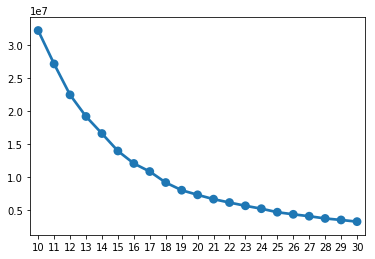

In [217]:
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
df_grouped_clustering = df_grouped.drop('Regione', 1)
elbow_k = []

for kclusters in  tqdm(range(10, 31)):
 
        # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
        kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(df_venues5)
 
        # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
        labels = kmeans_model.labels_
        
        # Sum of distances of samples to their closest cluster center
        interia = kmeans_model.inertia_
        elbow_k.append(interia)
    
sns.pointplot(list(range(10,31)),elbow_k, fit_reg=False)



### Let's try to plot the new 20 regions!

# This is just a Markercluster test

In [325]:
df_cluster_w=df_venues5.copy()
df_cluster_w["Venue Latitude"] = df_cluster_w["Venue Latitude"]
df_cluster_w["Venue Longitude"] = df_cluster_w["Venue Longitude"] 
df_cluster_w=df_cluster_w.drop(columns=["Altitude","AvgHousehold"])


colors_array = ['beige', 'black', 'blue', 'cadetblue', 'darkblue', 'darkgreen', 'darkpurple', 'darkred', 'gray', 'green', 'lightblue', 'lightgray', 'lightgreen', 'lightred', 'orange', 'pink', 'purple', 'red', 'white','blue','beige']

#df_venues5=df_venues5.drop(columns=['Cluster Label'])
#df_venues5=df_venues5.drop(columns=['city','Cluster Label','color' ])
kmeans = KMeans(n_clusters=20, max_iter=10000).fit(df_cluster_w)
# add clustering labels

df_venues6 =df_venues5.copy()
df_venues6.insert(0, 'Cluster Label', kmeans.labels_)


colors_series = df_venues6.apply(lambda row: colors_array[int(row["Cluster Label"])], axis=1)
df_venues6["color"] = colors_series


# create map of New York using latitude and longitude values
rome_lat = df_lib.loc[df_lib['city'] == "Roma", "lat"].values[0]
rome_lng = df_lib.loc[df_lib['city'] == "Roma", "lng"].values[0]
map_italy = folium.Map(location=[rome_lat, rome_lng], zoom_start=6)
from folium.plugins import FastMarkerCluster

markerCluster = folium.plugins.MarkerCluster().add_to(map_italy)

"""
df_lib_short = df_lib[df_lib.popu > 8000]
print(df_lib_short.shape)
"""
# add markers to map

callback = ('function (row) {' 
                'var colors = ["red","blue","gray","darkred","lightred","orange","beige","green","darkgreen","lightgreen",    "darkblue",    "lightblue",    "purple",    "darkpurple",    "pink",    "cadetblue",    "lightgray",    "black",    "red",    "blue", "beige"];'
                'var color_x = colors[row[2]];'
                'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: color_x});'
                'var icon = L.AwesomeMarkers.icon({'
                "icon: 'info-sign',"
                "iconColor: color_x,"
                "markerColor: color_x,"
                "prefix: 'glyphicon',"
                "extraClasses: 'fa-rotate-0'"
                    '});'
                'marker.setIcon(icon);'
                'return marker};')
#col = colors[int(row['Cluster Label'])]
  
map_italy.add_child(FastMarkerCluster(df_venues6[['Venue Latitude', 'Venue Longitude', "Cluster Label"]].values.tolist(),callback=callback))
             
    
#display(map_italy)

In [425]:
df_lib2=df_lib2.drop(df_lib2[df_lib2.duplicated(['City'])].index)


# We are gonna check different end-results, depending on how much weight do we do to the Geographical position

In [445]:
map_k_1 = None
map_k_2 = None
for lweight in range(1, 21, 2):
    df_cluster_w=df_venues5.copy()
    df_cluster_w["Venue Latitude"] = df_cluster_w["Venue Latitude"]/lweight
    df_cluster_w["Venue Longitude"] = df_cluster_w["Venue Longitude"]/lweight
    df_cluster_w=df_cluster_w.drop(columns=["Altitude","AvgHousehold"])


    colors_array = ['beige', 'black', 'blue', 'cadetblue', 'darkblue', 'darkgreen', 'darkpurple', 'darkred', 'gray', 'green', 'lightblue', 'lightgray', 'lightgreen', 'lightred', 'orange', 'pink', 'purple', 'red', 'white','blue','beige']

    #df_venues5=df_venues5.drop(columns=['Cluster Label'])
    #df_venues5=df_venues5.drop(columns=['city','Cluster Label','color' ])
    # add clustering labels

    flag=True
    while flag:
        kmeans = KMeans(n_clusters=20).fit(df_cluster_w)
        # add clustering labels
        df_venues6 =df_venues5.copy()
        df_venues6=df_venues6.drop(columns=["Altitude","AvgHousehold"])
        df_venues6["city"] = df_venues4["city"]
        df_venues6 = df_venues6.groupby("city").mean()
        df_venues6["Venue Latitude"] = df_venues6["Venue Latitude"]/lweight
        df_venues6["Venue Longitude"] = df_venues6["Venue Longitude"]/lweight
        city_label = kmeans.predict(df_venues6)
        df_check = df_venues6
        df_check["check"] = city_label
        flag=False
        if any([len(df_check[df_check.check == x])<30 for x in range(20)]) == True:
            print(pd.Series([len(df_check[df_check.check == x])<30 for x in range(20)]).sum())
            flag = True







    from IPython.core.display import HTML
    from IPython.display import display
    import matplotlib.colors as colors
    # create map of New York using latitude and longitude values
    rome_lat = df_lib.loc[df_lib['city'] == "Roma", "lat"].values[0]
    rome_lng = df_lib.loc[df_lib['city'] == "Roma", "lng"].values[0]
    map_italy = folium.Map(location=[rome_lat, rome_lng], zoom_start=5)



    rainbow = [colors.rgb2hex(tuple(np.random.randint(256, size=3)/256)) for i in list(range(21))]


    df_lib_temp = df_lib2.rename(columns={"City":"city"})
    df_lib_temp.index=df_lib_temp.city
    df_lib_temp = df_lib_temp.drop(columns="city")
    df_lib_short=pd.merge(left=df_venues6, right=df_lib_temp, how="left", on="city")


    df_lib_short["clab"] = city_label
    df_lib_short = df_lib_short[df_lib_short.popu > 1000]
    df_lib_short=df_lib_short.dropna()
    print(df_lib_short.shape)

    # add markers to map
    for lat, lng, clab in zip(df_lib_short['lat'], df_lib_short['lng'], df_lib_short['clab']):

        folium.CircleMarker(
            [lat, lng],
            radius=4,
            color=rainbow[int(clab)],
            fill=True,
            fill_color=rainbow[int(clab)],
            fill_opacity=0.7,
            parse_html=False).add_to(map_italy)  

    #display(map_italy)
    map_italy.save('map{}.html'.format(lweight))
    if lweight == 1:
        map_k_1 = map_italy
    elif lweight == 7:
        map_k_2 = map_italy

(2410, 101)
(2410, 101)
1
(2410, 101)
(2410, 101)
(2410, 101)
1
(2410, 101)
(2410, 101)
(2410, 101)
(2410, 101)
(2410, 101)


In [446]:
display(map_k_1)

In [447]:
display(map_k_2)